# **Health Care Data Set**

## Load the Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

## Review the health care data set

In [2]:
df = pd.read_csv('/content/file_downloaded')
df.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         1000 non-null   int64  
 6   HbA1c      1000 non-null   float64
 7   Chol       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 109.5+ KB


In [4]:
df['ID'].nunique()

800

In [5]:
df['CLASS'].nunique()

5

In [6]:
df['CLASS'].value_counts()

,count
CLASS,
Y,840
N,102
P,53
Y,4
N,1



Y= Yes, N = No, P = Prediabetes.
Expected 3 Classes, Got 5.

In [7]:
df['CLASS'].unique()

array(['N', 'N ', 'P', 'Y', 'Y '], dtype=object)

There are spaces in front of Y and N. Let's strip those.

In [8]:
df['CLASS'] = df['CLASS'].str.replace(' ', '')
df['CLASS'].value_counts()

,count
CLASS,
Y,844
N,103
P,53


In [9]:
df['Gender'].nunique()

3

In [10]:
df['Gender'].value_counts()

,count
Gender,
M,565
F,434
f,1


In [11]:
df['Gender'].unique()

array(['F', 'M', 'f'], dtype=object)

In [12]:
df['Gender'] = df['Gender'].apply(str.upper)
df['Gender'].value_counts()

,count
Gender,
M,565
F,435


<Axes: xlabel='Gender'>

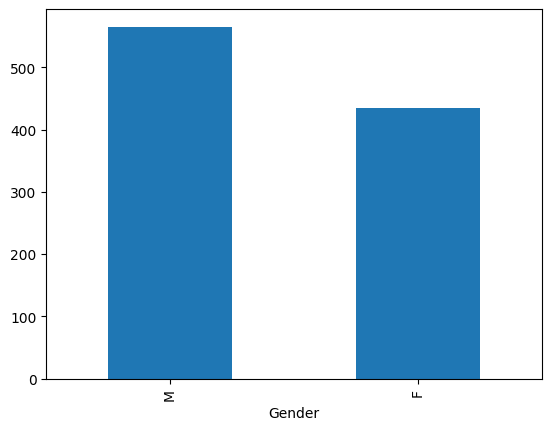

In [13]:
df['Gender'].value_counts().plot(kind = 'bar')

In [14]:
df['AGE'].nunique()

50

### Feature Engineering:
Create Age Range buckets to represent general healthcare reporting formats

In [15]:
age_range_buckets = ["[{0} - {1})".format(age, age + 10) for age in range(20, 100, 10)]
age_range_buckets

['[20 - 30)',
 '[30 - 40)',
 '[40 - 50)',
 '[50 - 60)',
 '[60 - 70)',
 '[70 - 80)',
 '[80 - 90)',
 '[90 - 100)']

In [16]:
df['age_range'] = pd.cut(x=df['AGE'], bins=8, labels=age_range_buckets)
df.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS,age_range
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N,[60 - 70)
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N,[20 - 30)
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N,[60 - 70)
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N,[60 - 70)
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N,[30 - 40)


In [17]:
df['age_range'].value_counts()

,count
age_range,
[60 - 70),476
[70 - 80),274
[50 - 60),79
[40 - 50),58
[30 - 40),54
[80 - 90),36
[90 - 100),19
[20 - 30),4


In [18]:
# Select only numeric columns for correlation calculation
#correlation_values = df.corr()
import numpy as np
correlation_values = df.select_dtypes(include=np.number).corr()

In [19]:
correlation_values

,ID,No_Pation,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
ID,1.000000,0.064920,-0.065980,-0.094434,-0.102457,-0.007571,0.044390,-0.055908,0.026231,-0.064305,0.146142,0.049409
No_Pation,0.064920,1.000000,-0.088006,-0.019160,0.000692,-0.032057,-0.030171,-0.039885,-0.013357,-0.003171,0.113754,0.017719
AGE,-0.065980,-0.088006,1.000000,0.105092,0.054941,0.379136,0.036649,0.148204,-0.020038,0.016105,-0.087903,0.375956
Urea,-0.094434,-0.019160,0.105092,1.000000,0.624134,-0.023603,0.001852,0.040980,-0.036994,-0.007301,-0.011191,0.045618
Cr,-0.102457,0.000692,0.054941,0.624134,1.000000,-0.037412,-0.007097,0.056579,-0.023804,0.039479,0.009615,0.054746
HbA1c,-0.007571,-0.032057,0.379136,-0.023603,-0.037412,1.000000,0.177489,0.218556,0.028933,0.011057,0.073462,0.413350
Chol,0.044390,-0.030171,0.036649,0.001852,-0.007097,0.177489,1.000000,0.321789,0.103814,0.416665,0.076294,0.013678
TG,-0.055908,-0.039885,0.148204,0.040980,0.056579,0.218556,0.321789,1.000000,-0.083001,0.015378,0.144570,0.110757
HDL,0.026231,-0.013357,-0.020038,-0.036994,-0.023804,0.028933,0.103814,-0.083001,1.000000,-0.142079,-0.059275,0.072409
LDL,-0.064305,-0.003171,0.016105,-0.007301,0.039479,0.011057,0.416665,0.015378,-0.142079,1.000000,0.062795,-0.067322


<Axes: >

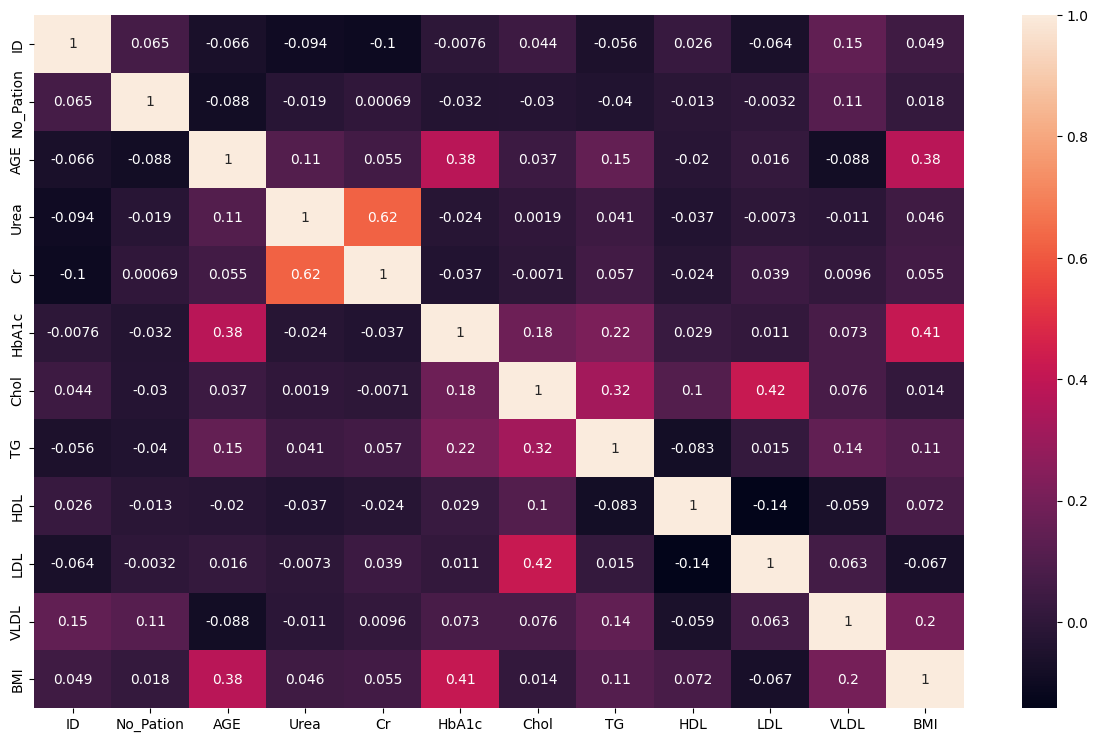

In [20]:
plt.figure(figsize=(15,9))
sns.heatmap(correlation_values,annot = True)

In [21]:
# No_Pation nuninique. Number of Partition is most likely an ID

df['No_Pation'].nunique()

961

In [22]:
df2 = df.drop(['ID','No_Pation','AGE'], axis=1) # since we have age range
df2.head()

,Gender,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS,age_range
0,F,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N,[60 - 70)
1,M,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N,[20 - 30)
2,F,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N,[60 - 70)
3,F,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N,[60 - 70)
4,M,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N,[30 - 40)


## **Insights Derived From the EDA**
**Data Cleaning:**

The CLASS variable had inconsistent values due to leading spaces, which were cleaned.

The Gender variable had capitalization inconsistencies, fixed by converting all values to uppercase.

**Feature Engineering:**

Created an age_range feature by grouping ages into 10-year intervals to enhance model performance.

**Data Exploration:**

The CLASS variable showed an imbalance (more "No" diabetes cases than "Yes" or "Prediabetes"), which impacts model selection.

Gender distribution was visualized, showing the number of male and female participants.

A correlation heatmap identified relationships between features, such as a positive correlation between Urea and Cr.

ID and No_Pation were identified as unique identifiers and removed for modeling.

**Overall Insights:**

Data quality issues were addressed, and feature relationships were explored.

The class imbalance in the CLASS variable is important for model training.

Feature engineering (age_range) improved dataset suitability for modeling.

In short, the EDA helped identify data quality issues, explore feature relationships, and provided insights that guide model preparation.

## **ML Modeling**

## Train Test Split

In [23]:
# Split data into features (X) and target (y)
X = df2.drop('CLASS', axis=1)
y = df2['CLASS']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (800, 11)
X_test shape: (200, 11)
y_train shape: (800,)
y_test shape: (200,)


## Encode Categorical Variables

In [24]:
# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the 'Gender' column
X_train['Gender'] = le.fit_transform(X_train['Gender'])
X_test['Gender'] = le.transform(X_test['Gender'])

# Fit and transform the 'age_range' column
X_train['age_range'] = le.fit_transform(X_train['age_range'])
X_test['age_range'] = le.transform(X_test['age_range'])

# Encode CLASS- y_train
# Fit and transform the target variable for the training set
y_train = le.fit_transform(y_train)

# Transform the target variable for the test set using the same encoder
y_test = le.transform(y_test)

In [25]:
X_train['Gender'].value_counts()

,count
Gender,
1,456
0,344


In [26]:
X_train['age_range'].value_counts()

,count
age_range,
4,379
5,223
3,67
2,44
1,44
6,28
7,12
0,3


In [27]:
X_train.head()

,Gender,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,age_range
29,0,4.3,49,4.0,5.6,1.4,1.4,3.6,0.6,22.0,3
535,1,2.7,38,8.8,4.8,1.3,1.7,1.6,2.0,26.0,4
695,1,2.9,35,11.5,4.9,2.1,2.3,1.8,0.8,33.0,6
557,1,3.2,49,6.7,4.6,1.2,1.3,2.8,0.5,30.2,4
836,0,5.9,74,12.4,5.5,1.3,1.6,1.7,1.9,27.0,4


In [28]:
scaler = MinMaxScaler()

In [29]:
columns_to_scale = ['Urea','Cr','HbA1c','Chol','TG','HDL','LDL','VLDL','BMI']
columns_scaled = ['Urea_scaled','Cr_scaled','HbA1c_scaled','Chol_scaled','TG_scaled','HDL_scaled','LDL_scaled','VLDL_scaled','BMI_scaled']
scale_values = X_train[columns_to_scale].values
scaled_array = scaler.fit_transform(scale_values)
X_train_scaled = pd.DataFrame(scaled_array, columns=columns_scaled)
X_train_scaled.head()

,Urea_scaled,Cr_scaled,HbA1c_scaled,Chol_scaled,TG_scaled,HDL_scaled,LDL_scaled,VLDL_scaled,BMI_scaled
0,0.161702,0.054156,0.205298,0.565657,0.081481,0.123711,0.329787,0.014925,0.104348
1,0.093617,0.040302,0.523179,0.484848,0.074074,0.154639,0.117021,0.056716,0.243478
2,0.102128,0.036524,0.701987,0.494949,0.133333,0.216495,0.138298,0.020896,0.486957
3,0.114894,0.054156,0.384106,0.464646,0.066667,0.113402,0.244681,0.011940,0.389565
4,0.229787,0.085642,0.761589,0.555556,0.074074,0.144330,0.127660,0.053731,0.278261


## Instantiate Models

creating instances of machine learning model classes

In [41]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC(gamma='scale')))
models.append(('RFC', RandomForestClassifier(n_estimators=100)))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('XGB',XGBClassifier()))

In [42]:
results = []
names = []

## Cross Validation

In [43]:
from sklearn.model_selection import KFold, cross_val_score # Import necessary classes

In [44]:

# Define the number of folds for k-fold cross-validation
num_folds = 5

# Iterate through the models
for name, model in models:
  # Create a KFold object
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

  # Perform cross-validation
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')

  # Store the results
  results.append(cv_results)
  names.append(name)

  # Print the mean and standard deviation of the accuracy scores
  print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

LR: 0.8737 (0.0115)
KNN: 0.8750 (0.0213)
NB: 0.9363 (0.0232)
SVC: 0.8387 (0.0183)
RFC: 0.9800 (0.0092)
DTR: 0.9738 (0.0047)
XGB: 0.9850 (0.0085)


## Make Predictions with best performing Model

In [45]:
# Since XGB is the best performing model based on the cross-validation results
best_model = XGBClassifier()

# Train the best model on the entire training dataset
best_model.fit(X_train, y_train)

# Make predictions on the test dataset
y_pred = best_model.predict(X_test)

In [46]:
y_pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [47]:
# Evaluate the performance of the best model on the test dataset
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best model on the test dataset: {accuracy:.4f}")

Accuracy of the best model on the test dataset: 0.9850


In [48]:
# Generate classification report and confusion matrix
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)




              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.86      1.00      0.92         6
           2       0.99      0.99      0.99       173

    accuracy                           0.98       200
   macro avg       0.93      0.98      0.96       200
weighted avg       0.99      0.98      0.99       200

Confusion Matrix:
[[ 20   0   1]
 [  0   6   0]
 [  1   1 171]]


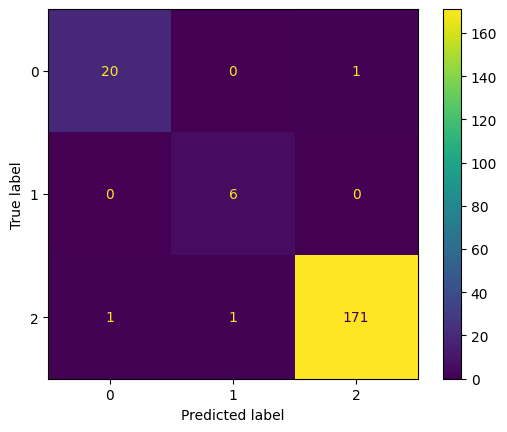

In [49]:
# visualize the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

**What Machine Learning Problems Were Solved?**

The primary machine learning problem is multi-class classification to predict the CLASS variable (diabetes status: "Y", "N", "P").

**Model Evaluation:**
Cross-Validation: The models were evaluated using 5-fold cross-validation, with accuracy as the scoring metric. The mean and standard deviation of accuracy were reported.

**Performance on Test Data:** After selecting the XGBoost Classifier, performance was measured using accuracy, a classification report (precision, recall, F1-score), and a confusion matrix.

**Best Model:**
XGBoost Classifier was the best-performing model, showing the highest average accuracy and lowest standard deviation.
